## 0 Import all neccesary packages

In [1]:
#Within AS
# Caching Rate
import random
from multiprocessing import Queue
import sys
import sqlite3

import re
import optparse
import logging
import numpy
import logging
from visualize import visualizer as vis


import threading
from user import User

import sched, time
from topology_manager import TopologyManager, Paths, SocialPaths
import tempfile

import matplotlib.pyplot as plt
import networkx as nx

from zipf import gen_biased_zipf_requests, gen_zipf_requests, gen_bilateral_biased_zipf_requests
from Autonomous_System import AS
import warnings
warnings.filterwarnings('ignore')
from statistics import mean
import os

In [2]:
def zipf_generator(num_of_content = 100, num_of_request = 1000, offset = 0):
    alpha = 1
    req, pattern = gen_bilateral_biased_zipf_requests(alpha = 1,number_of_content = num_of_content, number_of_request = num_of_request, offset = offset)
    return pattern

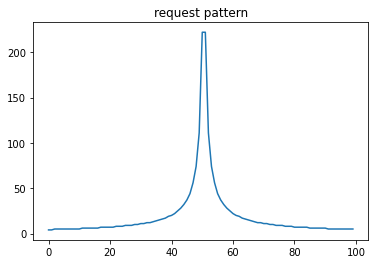

In [3]:
pattern = zipf_generator(num_of_content = 100, num_of_request = 1000, offset = 0)
plt.plot(pattern.keys(), pattern.values())
plt.title('request pattern')
plt.show()

## 1 Prepare instruaction parser

In [4]:
parser = optparse.OptionParser()
parser.add_option("-c", "--cache-size-per-node",
              dest="cache_size_per_node",
              help="space of cache allocated for every node in the topology",
              type=int,
              )
parser.add_option("-s", "--strategy",
              dest="caching_strategy",
              help="caching Strategy used for evaluating the trace"
              )
parser.add_option("-u", "--social-connections",
              dest="social_graph",
              help='social connections between users of the trace. Every trace includes users that executes actions.'
)
parser.add_option("-t", "--topology",
              dest="network_topology",
              help='network topology used for executing the trace.'
)
parser.add_option("-f", "--trace-file",
              dest="trace",
              default="",
              help='the trace to be executed',
)
parser.add_option("-p", "--replacement-policy",
              dest="replacement_policy",
              help='replacement policy used at every network node.',
)
parser.add_option("-m", "--mobility-enabled",
              dest="mobility_enabled",
              default=False,
              action="store_true",
              help="Enable mobility of users"
)
parser.add_option("-d", "--debug",
              dest="debug",
              default=False,
              action="store_true",
              help="Enable debugging options"
)
parser.add_option("-r", "--step-printing",
              dest="step_printing",
              default="",
              help = ""
)
parser.add_option("-z", "--zipf",
              dest="zipf",
              default=False,
              action="store_true",
              help = ""
)
parser.add_option("-a", "--zipf_parameter",
              dest="zipf_parameter",
              default=1.0,
              help="set zipf parameters",
              type=float,
)
parser.add_option("-e", "--method",
                 dest = "method",
                 default='random',
                 help = "random/geographical/onepublisher"
)
parser.add_option("-g", "--single-user",
                 dest = "single",
                 default=False,
                 action="store_true",
                 help = "if set, each topology node comes with only one user"
)
parser.add_option("-v", "--verbose",
                 dest = "verbose",
                 default=False,
                 action="store_true",
                 help = "if set, print cache storage info"
)

<Option at 0x118f9c5e0: -v/--verbose>

In [5]:
def setup_logger(logger_name, log_file, level=logging.INFO, format_style = '%(asctime)-15s %(message)s',verbose=True):
    l = logging.getLogger(logger_name)
    formatter = logging.Formatter(format_style)
    fileHandler = logging.FileHandler(log_file, mode='w')
    fileHandler.setFormatter(formatter)
    l.addHandler(fileHandler)
    streamHandler = logging.StreamHandler()
    streamHandler.setFormatter(formatter)
    l.addHandler(streamHandler)
    l.setLevel(level)
    return l

# 🤟🏻 2 define simulation program

In [6]:
class Executor(object):
    def __init__(self, logger, social_graph, topology, cache_size, caching_strategy, cache_policy, sequence_filename = '', mobility_enabled = False, step_printing = [], topology_file = None, zipf = False, method = 'random', single = False, verbose = False):
        self.lock = threading.Lock()
        self.condition = threading.Condition()
        #########################################
        #Initialize AS
        ##########################################
        nodes = list(topology.nodes())
        try:
            nodes.remove("server")
        except:
            pass
        self.AS = AS(nodes, True)
        logger.info("initialized Autonomous System")
        #########################################
        # Configuration
        #########################################
        self.round = 0
        ## Configure Cache
        self.num_of_request = 2000
        self.initialized_server = False
        self.num_of_content = 1000
        self.contents = ["/content/%s"%str(i) for i in range(self.num_of_content)]
        #########################################
        self.conf = {}
        self.conf['caching_strategy'] = caching_strategy
        self.conf['cache_policy'] = cache_policy
        self.conf['sequence_from_file'] = sequence_filename != ''
        self.conf['step_printing'] = step_printing
        self.method = method
        self.zipf_para = 1
        if self.conf['step_printing'] != None:
            self.steps = 0
        else:
            self.steps = None
        self.verbose = verbose
        #print("singledemo",single)
        #print("zipfdemo",zipf)

        ##########################################3
        # The topology manager handles user connection to CCN nodes.
        self.request_nodes = list(topology)
        self.topology = topology
        self.add_server_node()
        if single:
            self.social_nodes = self.topology
        ##############################################
        # Debugging
        #print(self.topology.nodes())
        logger.debug('Topology manager, connect users started')
        topology_coords = nx.spring_layout(topology)
        #topology_coords = {}
        #for node in topology.nodes():
        #    topology_coords[node] = (
        #            random.randint(0, 100),
        #            random.randint(0, 100)
        #    )
        self.topology_coords = topology_coords
        if single:
            self.social_graph = self.topology
            self.topology_nodes = TopologyManager(self.topology, self.topology, topology_coords, mobility_enabled, topology_file = topology_file)
        else:
            self.topology_nodes = TopologyManager(self.topology, self.social_graph, topology_coords, mobility_enabled, topology_file = topology_file)
        # 社交用户与节点之间关系为随机指定型
        # 后续的请求是用户发出的，所以，主要是要看如何将用户与请求 Pattern之间建立起关系
        self.topology_nodes.set_method(self.method)
        # 从网络中随机初始化网络节点
        # 从Social Network中随机初始化社交节点位置
        if not single:
            for user in social_graph.nodes():
                # update user node(user,pos)
                # initiate user position(coords_user)
                # 将用户映射到最近的拓扑节点上
                self.topology_nodes.update_user_position(user,(random.randint(0, 100), random.randint(0, 100)))
            self.topology_nodes.update_all_users_position()
        else:
            # 在单用户场景中，我们需要将用户初始化于相应的节点中
            for node in topology.nodes():
                    #TODO
                    self.topology_nodes.update_user_node(node,node)
        logger.debug('Topology manager, connect users finished')

        #
        self.users = {}
        for user in self.social_graph.nodes():
            self.users[user] = User(user)

        logger.debug('Start simulation')
        # debugging
        #print(self.topology_nodes.paths._path)

        self.sched = sched.scheduler(time.time, time.sleep)

        # Generate Sequence
        #print "generate sequence"
        if sequence_filename == '':
            self.generate_sequence()
        else:
            self.initialize_scheduler_from_file(sequence_filename)

        # Initialize Caches
        self.lock.acquire()
        # !!Cache Strategy Upper
        caching_strategy_upper = self.conf['caching_strategy'].upper()
        cm = getattr(getattr(__import__('cache_management.%s'%caching_strategy_upper), caching_strategy_upper), caching_strategy_upper)
        self.caches = cm(
                self.conf['cache_policy'],
                cache_size,
                self.social_graph,
                self.topology,
                self.topology_nodes,
                threshold = None
        )
        logger.debug('Loaded caching strategy')
        self.lock.release()
        self.initialize_catalog()
        ##//Initiate
    # Set Zipf parameter
    # default is 1.0
    def set_zipf_parameter(self,alpha):
        self.zipf_para = alpha
    
    def initialize_scheduler(self, offset = 0):
        self.sched = sched.scheduler(time.time, time.sleep)
        ########################
        # TODO 接上Server
        if not self.initialized_server:
            self.initialize_Server()
            self.initialized_server = True
        ##########################
        #self.extract_sequence()
        #########################
        # Pending
        # 插入ZipF请求
        print("Start Simulating!")
        self.gen_zipf_sequence(num_of_content = self.num_of_content, num_of_request = self.num_of_request, r = self.round, offset = offset)
        ######################

        assert not self.sched.empty()


    ##############################################
    #TODO: currently not being used
    def initialize_scheduler_from_file(self, filename):
        self.seq_file = open(filename, 'r')
        self.seq_n = 0
    
    def extract_sequence(self):
        line = self.seq_file.readline()
        while line != '': #Empty line, we reach the end of the sequence
            # Retrieve fields in a line
            # Line format
            # |timestamp | event | User | mobility_x | mobility_y
            result = re.match ("(?P<timestamp>[0-9]*\.[0-9]+)\t(?P<activity>Retrieve|Publish|retrieve|publish|Retrievecontent|Publishcontent)\t(?P<user>[0-9]+)\t\((?P<dependent>.*)\)\t\((?P<mobility_x>[0-9\.]*), ?(?P<mobility_y>[0-9\.]*)\)", line)
            if result != None:
                #print step result
                if self.steps != None and self.steps < len(self.conf['step_printing']) and float(result.group('timestamp')) > self.conf['step_printing'][self.steps]:
                    # debugging
                    print(self.steps)
                    self.sched.enter(self.seq_n * 0.01, 0, self.printStepSummary, (self.conf['step_printing'][self.steps],))
                    self.steps += 1
                # schedule an event (delay, priority, action, argument=())
                # delay, priority, action, argument=()
                # 使用的工具为：
                # 1 Producer2
                # 2 consumer
                # 3 consume_from_server
                pos = (float(result.group('mobility_x')), float(result.group('mobility_y')))
                if result.group('activity').lower() in ['publishcontent', 'publish']:
                    self.sched.enter(self.seq_n * 0.01, 0, self.producer2, (int(result.group('user')), pos, "/content/%s"%result.group('dependent').split(',')[0] ))
                # 两类consumer
                elif result.group(2).lower() == 'retrieve':
                    self.sched.enter(self.seq_n * 0.01, 0, self.consumer, (int(result.group('user')), pos,))
                elif result.group(2).lower() == 'retrievecontent':
                    #print(self.seq_n * 0.01, 0,self.consume_from_server, (int(result.group('user'))), pos, "/content/%s"%result.group('dependent').split(',')[0])
                    self.sched.enter(self.seq_n * 0.01, 0, self.consume_from_server, (int(result.group('user')), pos, "/content/%s"%result.group('dependent').split(',')[0]))
            else:
                print("repr line: %s"%repr(line))
                exit(-1)
            self.seq_n+=1
            line=self.seq_file.readline()
    def initialize_catalog(self):
        self.f = tempfile.NamedTemporaryFile(delete=True, dir='/tmp/')
        self.conn = sqlite3.connect(self.f.name)
        self.c = self.conn.cursor()

        #c.execute('''DROP table catalog''')
        self.c.execute('''CREATE TABLE catalog
                     (content_name text, publisher int, date double, refer text, refered_level int, topic int)''')

    def generate_sequence(self, sequence = []):
        assert type(sequence) == list
        if sequence == []:
            self.sequence = [random.randint(0, len(self.social_graph.nodes())-1) \
                for i in range(0, len(self.social_graph)*40)]
            random.shuffle(self.sequence)
        else:
            self.sequence = sequence

    ###################################
    # 加入Server节点
    def add_server_node(self):
        node = random.choice(list(self.topology.nodes()))
        self.topology.add_node("server")
        self.topology.add_edge(node,"server")
        self.server = "server"
    ############################################
    # Initialize Server
    # 随机选取一个节点
    # 作为Server接上内容
    def initialize_Server(self):
        #################################
        # TODO
        # 找到中心节点
        # 加入一个Server节点
        # Pending
        for content in self.contents:
            self.sched.enter(self.seq_n * 0.01, 0, self.producer3, (self.server, content))
        #################################

    #################################
    # 生成符合Zipf分布的请求，并插入仿真器中
    # TODO:a Zipf sequence generator
    # Pending 01 将请求插入进编辑器中
    #def generate_Zipf_sequence(self,sequence = []):
    def zipf_generator(self,num_of_content, num_of_request, offset):
        alpha = self.zipf_para
        req, _ = gen_bilateral_biased_zipf_requests(alpha = alpha,number_of_content = num_of_content, number_of_request = num_of_request, offset = offset)
        return req
        
    def gen_zipf_sequence(self, num_of_content = 1000, num_of_request = 10000, r = 0, offset = 0):
        sequence = self.zipf_generator(num_of_content, 10*num_of_content, offset)
        if len(sequence)>=num_of_request:
            requests = sequence[:num_of_request]
        else:
            while(num_of_content):
                requests += sequence[:min(num_of_sequence,len(sequence))]
        #consume_from_server(user,position, contentname)
        # nodes must convert to list, or error appears
        if self.conf['caching_strategy'].upper() == "POP":
            for request in requests:
                ##############################################
                if self.steps != None and self.steps < len(self.conf['step_printing']) and float(result.group('timestamp')) > self.conf['step_printing'][self.steps]:
                        self.sched.enter(self.seq_n * 0.01, 0, self.printStepSummary, (self.conf['step_printing'][self.steps],))
                        self.steps += 1
                ##############################################
                request_node = random.choice(self.request_nodes)
                while(request_node == "server"):
                    request_node = random.choice(self.request_nodes)
                #consume_from_server(user,position, contentname)
                #目标是先从目标节点进行查找
                ## Scheduler 的用法
                # scheduler.enter(delay, priority, action, argument=(), kwargs={})
                # Pending# consume from server 应该被改成从目标中获取
                #print(self.social_graph.nodes())
                #pos = self.topology_coords[request_node]
                #self.sched.enter(self.seq_n * 0.01, 0, self.consume_from_server, (int(result.group('user')), pos, "/content/%s"%result.group('dependent').split(',')[0]))
                req = self.contents[request]
                # print(request_node, type(pos), type(req))
                # print(self.seq_n * 0.01, 0, self.consume_from_server, request_node, pos, req)

                self.sched.enter(self.seq_n * 0.01, 0, self.consume_from_target, (request_node, req))
                self.seq_n+=1
        else:
            for request in requests:
                ##############################################
                #if self.steps != None and self.steps < len(self.conf['step_printing']) and float(result.group('timestamp')) > self.conf['step_printing'][self.steps]:
                #        self.sched.enter(self.seq_n * 0.01, 0, self.printStepSummary, (self.conf['step_printing'][self.steps],))
                #        self.steps += 1
                ##############################################
                request_node = random.choice(self.request_nodes)
                while(request_node == "server"):
                    request_node = random.choice(self.request_nodes)
                #consume_from_server(user,position, contentname)
                pos = self.topology_coords[request_node]
                req = self.contents[request]
                # print(request_node, type(pos), type(req))
                self.sched.enter(self.seq_n * 0.01, 0, self.consume_from_server,(request_node, pos, req))

            
                self.seq_n+=1
        print("total seq num: ",self.seq_n)
     #################################
    
    def run(self, offset = 0):
        #print "the process begins"
        self.initialize_scheduler(offset = offset)
        self.sched.run()
        self.round += 1
        time.sleep(2)

        
    def __del__(self):
        self.conn.close()
    # 使用的是这一个！！
    # 将文件插入到数据库中
    def producer3(self, social_publisher, content, reference = '', topic = 0):
        #self.topology_nodes.update_user_position(social_publisher, position)
        self.caches.incr_publish()
        #content_name = "/friend%i/%i"%(social_publisher, self.stats.increase_messages())
        #print("node",social_publisher, "publish",content)
        content_name = "%s"%content
        _new_content_name = content_name
        if reference == '':
            _ref_level = 0
        else:
            #Select 
            _ref_level = 0
            for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" LIMIT 1'%reference):
                _ref_level = row[4]+1
                _new_content_name = row[0]
                topic = row[5]
            assert _ref_level == 1, _ref_level
        self.c.execute("INSERT INTO catalog VALUES (\"%s\",'%s', '%s', '%s', %d, %d);"%(content_name, social_publisher, time.time(), reference, _ref_level, topic))
        self.lock.acquire()
        self.caches.post_production(_new_content_name, social_publisher)
        self.lock.release()
    # 使用的是这一个！！
    # 将文件插入到数据库中
    def producer2(self, social_publisher, position, content, reference = '', topic = 0):
        self.topology_nodes.update_user_position(social_publisher, position)
        self.caches.incr_publish()
        #content_name = "/friend%i/%i"%(social_publisher, self.stats.increase_messages())
        #print("node",social_publisher, "publish",content)
        content_name = "%s"%content
        _new_content_name = content_name
        if reference == '':
            _ref_level = 0
        else:
            #Select 
            _ref_level = 0
            for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" LIMIT 1'%reference):
                _ref_level = row[4]+1
                _new_content_name = row[0]
                topic = row[5]
            assert _ref_level == 1, _ref_level
        self.c.execute("INSERT INTO catalog VALUES (\"%s\",'%s', '%s', '%s', %d, %d);"%(content_name, social_publisher, time.time(), reference, _ref_level, topic))
        self.lock.acquire()
        self.caches.post_production(_new_content_name, social_publisher)
        self.lock.release()
    ## Producer with position This is already abandoned~
    def producer(self, social_publisher, position, reference = '', topic = 0):
        logger.error("WARNING, this function is deprecated")
        exit(-1)
        self.topology_nodes.update_user_position(social_publisher, position)
        self.caches.incr_publish()
        content_name = "/friend%i/%i"%(social_publisher, self.stats.increase_messages())
        _new_content_name = content_name
        if reference == '':
            _ref_level = 0
            topic = self.users[social_publisher].decide_next_topic()
        else:
            #Select 
            _ref_level = 0
            for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" LIMIT 1'%reference):
                _ref_level = row[4]+1
                _new_content_name = row[0]
                topic = row[5]
            assert _ref_level == 1, _ref_level
        self.c.execute("INSERT INTO catalog VALUES (\"%s\",'%s', '%s', '%s', %d, %d);"%(content_name, social_publisher, time.time(), reference, _ref_level, topic))
        self.lock.acquire()
        self.caches.post_production(_new_content_name, social_publisher)
        self.lock.release()
    #consume_from_server(user,position, contentname)
    def consume_from_server(self, social_issuer, position, content_name):
        #print("Here")
        #print "consume_from_server %s"%content_name
        # 首先将用户的位置进行更新为新的地点
        self.topology_nodes.update_user_position(social_issuer, position)
        # 然后
        content_retrieved = {}
        last = 0
        #寻找到存储这个内容的节点
        # Print Flag
        #print("Consume: ",content_name)
        for row in self.c.execute('SELECT * FROM catalog WHERE content_name == \"%s\" LIMIT 1'%( content_name )):
            # row的格式是：
            # content_name text, publisher int, date double, refer text, refered_level int, topic int
            last = row[0]
            reference = row[3]
            referer_level = row[4]
            topic = row[5]
            interest = last
            #从拓扑图中获取路径
            # 由于获取的时候
            # Print Flag
            
            path = self.topology_nodes.get_path(social_issuer, row[1])
            # Retrieve content and calculate statistics
            self.lock.acquire()
            self.caches._retrieve_from_caches(interest, path)
            self.lock.release()
        #if self.verbose:
        #    print(self.printStats())

    def consumer(self, social_issuer, position):
        self.topology_nodes.update_user_position(social_issuer, position)
        content_retrieved = {}
        for social_neighbour in self.social_graph.neighbors(social_issuer):
            topology_neighbour = self.topology_nodes[social_neighbour]
            last = 0
            
            for row in self.c.execute('SELECT * FROM catalog WHERE publisher=%s and date BETWEEN %2f AND %2f ORDER BY date DESC LIMIT 1'%(social_neighbour, time.time()-0.2, time.time())):
                last = row[0]
                reference = row[3]
                referer_level = row[4]
                topic = row[5]
                #detecting original consumer
                while referer_level > 0:
                    for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" ORDER BY date DESC LIMIT 1'%reference):
                        last = row[0]
                        reference = row[3]
                        referer_level = row[4]
                        topic = row[5]
                #print row
                interest = last
                path = self.topology_nodes.get_path(social_issuer, social_neighbour)
                self.lock.acquire()
                self.caches._retrieve_from_caches(interest, path)
                self.lock.release()
            if self.verbose:
                print(self.printStats())
#########################################################
    # TODO: 先从目标节点中尝试获取缓存信息，然后再尝试从Server处获取缓存信息
    # Pending 02
    def consume_from_target(self, consumer, content_name) :
        # 目标节点
        # Pending： 需要向目标节点发出请求
        # target = hash_target(content_name)
        content_retrieved = False
        target = self.AS.get_node(content_name)
        #print("Consume: ",content_name,"Target is: ", target)
        path_to_target = self.topology_nodes.get_path(consumer, target)
        path_to_server = self.topology_nodes.get_path(consumer, self.server)
        target_to_server = self.topology_nodes.get_path(target,self.server)
        self.lock.acquire()
        self.caches.stats.add_original_hop(len(path_to_server)-1)
        self.caches.retrieve_content(content_name, target, path_to_target,self.server, target_to_server)
        #try:
            #  从目标节点中进行获取内容
            # retrieve_content(self, interest, target, path_to_target, server, path_to_server):
        #    self.caches.retrieve_content(content_name, target, path_to_target,self.server, target_to_server)
        #except:
        #    self.caches._retrieve_from_caches(content_name, path_to_server)
        self.lock.release()
        #if self.verbose:
        #    print(self.printStats())
        return 0
#########################################################
    def get_expired_elements(self):
        # get last element of each social user
        #TODO: refactoring URGENT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        return 0
    def get_diversity(self):
        return self.stats.get_diversity(self.caches)
    def printStats(self):
        return self.caches.stats_summary()
    #############################################
    # print cache detail
    def printCaches(self):
        return self.caches.print_caches()
    ##############################################
    def printStepSummary(self, timestamp):
        print("=> {0} {1}".format(timestamp, self.caches.stats_summary()))
    def finishSimulation(self):
        del self.caches
        del self.topology_nodes 
        del self.sched
        self.c.close()
        self.lock.acquire()
        self.lock.release()
        self.condition.acquire()
        self.condition.notify()
        self.condition.release()

## 3 😋 Clear logger block

In [7]:
logger = logging.getLogger('logger')
while logger.handlers:
    logger.handlers.pop()
cache_info = logging.getLogger('cache_info')
while cache_info.handlers:
    cache_info.handlers.pop()
    cache_info = logging.getLogger('cache_info')

In [8]:
from importlib import reload
logging.shutdown()
reload(logging)

<module 'logging' from '/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/logging/__init__.py'>

## 4 😯Configure and run

In [33]:
import warnings
warnings.filterwarnings('ignore')

### 4.01 😎 Run POP(Zipf = 1, requests = 2000, topo = GEANT, hit_rate VS capability)

In [ ]:
args = '-c 5 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))

In [ ]:
result = []
simulate(options)

In [ ]:
result_10 = result

In [ ]:
args = '-c 3 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_6 = result

In [ ]:
args = '-c 13 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_26 = result

In [ ]:
args = '-c 15 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_30 = result

In [ ]:
args = '-c 18 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_36 = result

In [ ]:
args = '-c 10 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_20 = result

In [ ]:
result = {}
result[5] = result_6
result[10] = result_10
result[16] = result_16
result[20] = result_20
result[26] = result_26
result[30] = result_30
result[35] = result_36

In [ ]:
result

In [ ]:
if not os.path.exists('result'):
    os.mkdir('result')
os.chdir('result/')
if not os.path.exists('cache_size'):
    os.mkdir('cache_size')
os.chdir('cache_size')
filename = 'result_POP.pickle'
import pickle
f = open(filename, 'wb')
pickle.dump(result,f)
f.close()

In [ ]:
f = open(filename, 'rb')
re = pickle.load(f)
print(re)
f.close

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(result.keys()),list(float(mean(value)/2000) for value in result.values()))

### 4.02 😎 Run MPC(Zipf = 1, requests = 2000, topo = GEANT, hit_rate VS capability)

In [ ]:
args = '-c 3 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [31]:
result_5 = result

In [ ]:
args = '-c 5 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_10 = result

In [ ]:
args = '-c 8 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_15 = result

In [ ]:
args = '-c 10 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_20 = result

In [ ]:
args = '-c 13 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_25 = result

In [38]:
args = '-c 15 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-06-03 09:12:53,089 - root - INFO - Enable Debugging
2021-06-03 09:12:53,089 - root - INFO - Enable Debugging
2021-06-03 09:12:53,090 - root - DEBUG - Mobility disabled
2021-06-03 09:12:53,090 - root - DEBUG - Mobility disabled
2021-06-03 09:12:53,091 - root - DEBUG - Step printing activated
2021-06-03 09:12:53,091 - root - DEBUG - Step printing activated
2021-06-03 09:12:53,091 - root - DEBUG - Social Graph loaded
2021-06-03 09:12:53,091 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 674 ms, sys: 36.9 ms, total: 710 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 542 , stretch: 0.8415 hop_reduction: 0.1585 get_diversity: 0.1847 caching_operations: 1815 eviction_operations: 1815 Satisfied by caches: 542 _interest: 2000, get_rch: 0.271
#####################################################################
Round#  2
Sta

In [39]:
 result

[542, 661, 648, 779, 824, 780, 761, 753, 787, 759]

In [ ]:
args = '-c 18 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_35 = result

In [ ]:
result = {}
result[5] = result_5
result[10] = result_10
result[15] = result_15
result[20] = result_20
result[25] = result_25
result[30] = result_30
result[35] = result_35

In [ ]:
result

In [ ]:
if not os.path.exists('result'):
    os.mkdir('result')
os.chdir('result/')
if not os.path.exists('cache_size'):
    os.mkdir('cache_size')
os.chdir('cache_size')
filename = 'result_MPC.pickle'
import pickle
f = open(filename, 'wb')
pickle.dump(result,f)
f.close()

# 5 😯 Configure and run for different zipf parameter

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
def simulate_zipf(options):
    logger = setup_logger('logger', 'example.log', level=logging.CRITICAL)
    cache_info = setup_logger('cache_info', 'cache_info.log', level = logging.CRITICAL)
    if options.debug:
        root = logging.getLogger()
        root.setLevel(logging.DEBUG)
        ch = logging.StreamHandler(sys.stdout)
        ch.setLevel(logging.DEBUG)
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        ch.setFormatter(formatter)
        root.addHandler(ch)
        root.info('Enable Debugging')
        # delivering original parameters
    CACHE_SIZE = options.cache_size_per_node
    CACHING_STRATEGY = options.caching_strategy
    ## Configure Cache
    RUNS = 10
    SOCIAL_GRAPH = options.social_graph
    TOPOLOGY_GRAPH = options.network_topology
    CACHE_STRUCTURE = options.replacement_policy
    SEQUENCE_FILE = options.trace
    ZIPF = options.zipf
    SINGLE = options.single
    VERBOSE = options.verbose
    ZIPF_PARAMETER = options.zipf_parameter
    if SEQUENCE_FILE == "":
        logging.error("no trace file, using random generation of messages.")
        exit()
    METHOD = options.method
    if METHOD not in ['random','geographical','onepublisher']:
        root.error("WARNING, method is not listed, set to random")
        METHOD = 'random'
    MOBILITY_ENABLED = options.mobility_enabled
    if MOBILITY_ENABLED:
        root.debug("Mobility enabled")
    else:
        root.debug("Mobility disabled")

    try:
        STEP_PRINTING = [float(x) for x in options.step_printing.split(",") if x != '']
        root.debug("Step printing activated")
    except IndexError:
        STEP_PRINTING = []
        root.debug("Step printing not activated")
    CACHE_STRUCTURE = re.match('([a-zA-Z0-9_]*(\((?P<params>([0-9]*\.?[0-9]*,? ?)*)\))?)', CACHE_STRUCTURE)
    assert CACHE_STRUCTURE != None
    CACHE_STRUCTURE = CACHE_STRUCTURE.group(1)
    # Import Social Graph
    # Social Graph from folder graphs
    G = getattr(__import__('graphs.%s'%SOCIAL_GRAPH), SOCIAL_GRAPH).G
    #plotGraph(G)
    root.debug('Social Graph loaded')
    #random.seed(10442)
    # Import Topology Graph as a new class(peterson and pharse as topology class)
    # social_graph is imported as a new class from folder graph, in this case, alibama
    petersen = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
    #plotGraph(petersen)
    # social_graph, topology, cache_size, caching_strategy, cache_policy, sequence_filename, mobility_enabled, step_printing, topology_file
    executor = Executor(logger,G, petersen, CACHE_SIZE, CACHING_STRATEGY, CACHE_STRUCTURE, SEQUENCE_FILE, MOBILITY_ENABLED, STEP_PRINTING, topology_file=TOPOLOGY_GRAPH, zipf = ZIPF, method = METHOD, single = SINGLE, verbose = VERBOSE) 
    executor.set_zipf_parameter(ZIPF_PARAMETER)
    offset = [0,2,4,6,8,10,12,14,16,18,20]
    for i in range(0, RUNS):
        #print(executor.caches.print_caches())
        print("#####################################################################")
        print("Round# ", i+1)
        %time executor.run(offset = offset[i])
        try:
            executor.caches.update_predict_result()
        except:
            "Not POP, do not update prediction"
        print(executor.printStats())
        if options.caching_strategy.upper() == "POP":
            result.append(executor.caches.stats._internal_hit)
        else:
            result.append(executor.caches.stats._hit)
        #print(executor.caches.print_caches())
        executor.caches.stats.reset()
        executor.seq_n = 0
        #print(executor.caches.pop)
    executor.finishSimulation()
    root.handlers.pop()
    logger = logging.getLogger('logger')
    while logger.handlers:
        logger.handlers.pop()
    cache_info = logging.getLogger('cache_info')
    while cache_info.handlers:
        cache_info.handlers.pop()

### 5.01 😎 Run Zipf(MPC, requests = 2000, topo = GEANT, hit_rate VS capability)

In [11]:
args = '-c 10 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 0.2'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

2021-05-27 11:04:32,222 - root - INFO - Enable Debugging
2021-05-27 11:04:32,223 - root - DEBUG - Mobility disabled
2021-05-27 11:04:32,224 - root - DEBUG - Step printing activated
2021-05-27 11:04:32,255 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 531 ms, sys: 22.2 ms, total: 553 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 19 , stretch: 1.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 1981 eviction_operations: 1981 Satisfied by caches: 19 _interest: 2000, get_rch: 0.0095
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 609 ms, sys: 24.9 ms, total: 633 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 26 , stretch: 1.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 

In [12]:
result_zipf_2 = result

In [13]:
args = '-c 10 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 0.4'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

2021-05-27 11:12:53,593 - root - INFO - Enable Debugging
2021-05-27 11:12:53,593 - root - DEBUG - Mobility disabled
2021-05-27 11:12:53,593 - root - DEBUG - Step printing activated
2021-05-27 11:12:53,594 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 614 ms, sys: 21.1 ms, total: 636 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 33 , stretch: 0.9997 hop_reduction: 0.0003 get_diversity: 0.9167 caching_operations: 1969 eviction_operations: 1969 Satisfied by caches: 33 _interest: 2000, get_rch: 0.0165
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 532 ms, sys: 21.1 ms, total: 553 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 56 , stretch: 0.9948 hop_reduction: 0.0052 get_diversity: 0.6923 ca

In [14]:
result_zipf_4 = result

In [15]:
args = '-c 10 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 0.6'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

2021-05-27 11:16:33,880 - root - INFO - Enable Debugging
2021-05-27 11:16:33,881 - root - DEBUG - Mobility disabled
2021-05-27 11:16:33,881 - root - DEBUG - Step printing activated
2021-05-27 11:16:33,881 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 627 ms, sys: 19.7 ms, total: 646 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 69 , stretch: 0.9917 hop_reduction: 0.0083 get_diversity: 0.5 caching_operations: 1958 eviction_operations: 1958 Satisfied by caches: 69 _interest: 2000, get_rch: 0.0345
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 615 ms, sys: 21.9 ms, total: 637 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 155 , stretch: 0.9667 hop_reduction: 0.0333 get_diversity: 0.3231 cach

In [16]:
result_zipf_6 = result

In [17]:
args = '-c 10 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 0.8'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

2021-05-27 11:20:14,268 - root - INFO - Enable Debugging
2021-05-27 11:20:14,268 - root - DEBUG - Mobility disabled
2021-05-27 11:20:14,269 - root - DEBUG - Step printing activated
2021-05-27 11:20:14,269 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 629 ms, sys: 20.3 ms, total: 650 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 194 , stretch: 0.9578 hop_reduction: 0.0422 get_diversity: 0.3182 caching_operations: 1927 eviction_operations: 1927 Satisfied by caches: 194 _interest: 2000, get_rch: 0.097
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 597 ms, sys: 21.3 ms, total: 618 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 298 , stretch: 0.9006 hop_reduction: 0.0994 get_diversity: 0.2174 

In [18]:
result_zipf_8 = result

In [19]:
args = '-c 10 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 1.0'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

2021-05-27 11:23:54,615 - root - INFO - Enable Debugging
2021-05-27 11:23:54,616 - root - DEBUG - Mobility disabled
2021-05-27 11:23:54,617 - root - DEBUG - Step printing activated
2021-05-27 11:23:54,618 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 559 ms, sys: 18.1 ms, total: 577 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 514 , stretch: 0.8417 hop_reduction: 0.1583 get_diversity: 0.1667 caching_operations: 1812 eviction_operations: 1812 Satisfied by caches: 514 _interest: 2000, get_rch: 0.257
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 573 ms, sys: 19.1 ms, total: 592 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 663 , stretch: 0.7284 hop_reduction: 0.2716 get_diversity: 0.1538 

In [20]:
result_zipf_10 = result

In [21]:
args = '-c 10 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 1.2'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

2021-05-27 11:27:34,982 - root - INFO - Enable Debugging
2021-05-27 11:27:34,982 - root - DEBUG - Mobility disabled
2021-05-27 11:27:34,983 - root - DEBUG - Step printing activated
2021-05-27 11:27:34,983 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 602 ms, sys: 25.2 ms, total: 627 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 789 , stretch: 0.7156 hop_reduction: 0.2844 get_diversity: 0.1277 caching_operations: 1618 eviction_operations: 1618 Satisfied by caches: 789 _interest: 2000, get_rch: 0.3945
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 545 ms, sys: 20.3 ms, total: 565 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 920 , stretch: 0.6145 hop_reduction: 0.3855 get_diversity: 0.1354

In [22]:
result_zipf_12 = result

In [23]:
result = {}
result[0.2] = result_zipf_2
result[0.4] = result_zipf_4
result[0.6] = result_zipf_6
result[0.8] = result_zipf_8
result[1.0] = result_zipf_10
result[1.2] = result_zipf_12

In [24]:
import os

In [26]:
if not os.path.exists('result'):
    os.mkdir('result')
os.chdir('result/')
if not os.path.exists('zipf'):
    os.mkdir('zipf')
os.chdir('zipf')
filename = 'result_MPC.pickle'
import pickle
f = open(filename, 'wb')
pickle.dump(result,f)
f.close()
os.chdir('../')
os.chdir('../')

# 6 (^_^)计算跳数

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
def simulate_hops(options):
    logger = setup_logger('logger', 'example.log', level=logging.CRITICAL)
    cache_info = setup_logger('cache_info', 'cache_info.log', level = logging.CRITICAL)
    if options.debug:
        root = logging.getLogger()
        root.setLevel(logging.DEBUG)
        ch = logging.StreamHandler(sys.stdout)
        ch.setLevel(logging.DEBUG)
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        ch.setFormatter(formatter)
        root.addHandler(ch)
        root.info('Enable Debugging')
        # delivering original parameters
    CACHE_SIZE = options.cache_size_per_node
    CACHING_STRATEGY = options.caching_strategy
    ## Configure Cache
    RUNS = 10
    SOCIAL_GRAPH = options.social_graph
    TOPOLOGY_GRAPH = options.network_topology
    CACHE_STRUCTURE = options.replacement_policy
    SEQUENCE_FILE = options.trace
    ZIPF = options.zipf
    SINGLE = options.single
    VERBOSE = options.verbose
    ZIPF_PARAMETER = options.zipf_parameter
    if SEQUENCE_FILE == "":
        logging.error("no trace file, using random generation of messages.")
        exit()
    METHOD = options.method
    if METHOD not in ['random','geographical','onepublisher']:
        root.error("WARNING, method is not listed, set to random")
        METHOD = 'random'
    MOBILITY_ENABLED = options.mobility_enabled
    if MOBILITY_ENABLED:
        root.debug("Mobility enabled")
    else:
        root.debug("Mobility disabled")

    try:
        STEP_PRINTING = [float(x) for x in options.step_printing.split(",") if x != '']
        root.debug("Step printing activated")
    except IndexError:
        STEP_PRINTING = []
        root.debug("Step printing not activated")
    CACHE_STRUCTURE = re.match('([a-zA-Z0-9_]*(\((?P<params>([0-9]*\.?[0-9]*,? ?)*)\))?)', CACHE_STRUCTURE)
    assert CACHE_STRUCTURE != None
    CACHE_STRUCTURE = CACHE_STRUCTURE.group(1)
    # Import Social Graph
    # Social Graph from folder graphs
    G = getattr(__import__('graphs.%s'%SOCIAL_GRAPH), SOCIAL_GRAPH).G
    #plotGraph(G)
    root.debug('Social Graph loaded')
    #random.seed(10442)
    # Import Topology Graph as a new class(peterson and pharse as topology class)
    # social_graph is imported as a new class from folder graph, in this case, alibama
    petersen = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
    #plotGraph(petersen)
    # social_graph, topology, cache_size, caching_strategy, cache_policy, sequence_filename, mobility_enabled, step_printing, topology_file
    executor = Executor(logger,G, petersen, CACHE_SIZE, CACHING_STRATEGY, CACHE_STRUCTURE, SEQUENCE_FILE, MOBILITY_ENABLED, STEP_PRINTING, topology_file=TOPOLOGY_GRAPH, zipf = ZIPF, method = METHOD, single = SINGLE, verbose = VERBOSE) 
    executor.set_zipf_parameter(ZIPF_PARAMETER)
    offset = [0,2,4,6,8,10,12,14,16,18,20]
    for i in range(0, RUNS):
        #print(executor.caches.print_caches())
        print("#####################################################################")
        print("Round# ", i+1)
        %time executor.run(offset = offset[i])
        AS_hops,original_hops = executor.caches.stats.get_hops()
        result.append(AS_hops)
        try:
            executor.caches.update_predict_result()
        except:
            "Not POP, do not update prediction"
        print(executor.printStats())
        #if options.caching_strategy.upper() == "POP":
        #    result.append(executor.caches.stats._internal_hit)
        #else:
        #    result.append(executor.caches.stats._hit)
        #print(executor.caches.print_caches())
        executor.caches.stats.reset()
        executor.seq_n = 0
        #print(executor.caches.pop)
    executor.finishSimulation()
    root.handlers.pop()
    logger = logging.getLogger('logger')
    while logger.handlers:
        logger.handlers.pop()
    cache_info = logging.getLogger('cache_info')
    while cache_info.handlers:
        cache_info.handlers.pop()

In [12]:
result = []

In [13]:
args = '-c 3 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_hops(options)

2021-06-02 18:23:03,831 - root - INFO - Enable Debugging
2021-06-02 18:23:03,832 - root - DEBUG - Mobility disabled
2021-06-02 18:23:03,833 - root - DEBUG - Step printing activated
2021-06-02 18:23:03,867 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 642 ms, sys: 32 ms, total: 674 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 123 , stretch: 0.9912 hop_reduction: 0.0088 get_diversity: 0.8333 caching_operations: 1919 eviction_operations: 1919 Satisfied by caches: 123 _interest: 2000, get_rch: 0.0615
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 667 ms, sys: 30.3 ms, total: 697 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 140 , stretch: 0.967 hop_reduction: 0.033 get_diversity: 0.2 cachin

In [14]:
result

[11674, 11448, 11152, 10389, 10526, 10155, 10313, 10691, 10469, 10475]

In [15]:
result_5 = result

In [16]:
args = '-c 5 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_hops(options)

2021-06-02 18:26:44,242 - root - INFO - Enable Debugging
2021-06-02 18:26:44,242 - root - DEBUG - Mobility disabled
2021-06-02 18:26:44,243 - root - DEBUG - Step printing activated
2021-06-02 18:26:44,243 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 644 ms, sys: 33.6 ms, total: 677 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 271 , stretch: 0.921 hop_reduction: 0.079 get_diversity: 0.2034 caching_operations: 1892 eviction_operations: 1892 Satisfied by caches: 271 _interest: 2000, get_rch: 0.1355
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 569 ms, sys: 27.2 ms, total: 596 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 440 , stretch: 0.8137 hop_reduction: 0.1863 get_diversity: 0.14 cac

In [17]:
result_10 = result

In [18]:
args = '-c 8 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_hops(options)

2021-06-02 18:30:24,566 - root - INFO - Enable Debugging
2021-06-02 18:30:24,567 - root - DEBUG - Mobility disabled
2021-06-02 18:30:24,568 - root - DEBUG - Step printing activated
2021-06-02 18:30:24,569 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 627 ms, sys: 22.4 ms, total: 650 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 371 , stretch: 0.8992 hop_reduction: 0.1008 get_diversity: 0.2208 caching_operations: 1856 eviction_operations: 1856 Satisfied by caches: 371 _interest: 2000, get_rch: 0.1855
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 638 ms, sys: 24.5 ms, total: 662 ms
Wall time: 15min 42s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 473 , stretch: 0.8213 hop_reduction: 0.1787 get_diversity: 0

In [19]:
result_15 = result

In [20]:
args = '-c 10 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_hops(options)

2021-06-02 20:38:56,336 - root - INFO - Enable Debugging
2021-06-02 20:38:56,337 - root - DEBUG - Mobility disabled
2021-06-02 20:38:56,337 - root - DEBUG - Step printing activated
2021-06-02 20:38:56,337 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 192 ms, sys: 4.15 ms, total: 196 ms
Wall time: 17min 34s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 369 , stretch: 0.8994 hop_reduction: 0.1006 get_diversity: 0.2069 caching_operations: 1882 eviction_operations: 1882 Satisfied by caches: 369 _interest: 2000, get_rch: 0.1845
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 227 ms, sys: 5.72 ms, total: 233 ms
Wall time: 7min 6s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 550 , stretch: 0.7762 hop_reduction: 0.2238 get_diversity

In [21]:
result_20 = result

In [22]:
args = '-c 13 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_hops(options)

2021-06-03 00:43:33,779 - root - INFO - Enable Debugging
2021-06-03 00:43:33,780 - root - DEBUG - Mobility disabled
2021-06-03 00:43:33,780 - root - DEBUG - Step printing activated
2021-06-03 00:43:33,781 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 236 ms, sys: 6.41 ms, total: 242 ms
Wall time: 54min 47s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 464 , stretch: 0.8506 hop_reduction: 0.1494 get_diversity: 0.2222 caching_operations: 1821 eviction_operations: 1821 Satisfied by caches: 464 _interest: 2000, get_rch: 0.232
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 230 ms, sys: 6.67 ms, total: 236 ms
Wall time: 31min 33s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 611 , stretch: 0.7518 hop_reduction: 0.2482 get_diversit

In [23]:
result_25 = result

In [24]:
args = '-c 15 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_hops(options)

2021-06-03 06:10:52,118 - root - INFO - Enable Debugging
2021-06-03 06:10:52,119 - root - DEBUG - Mobility disabled
2021-06-03 06:10:52,120 - root - DEBUG - Step printing activated
2021-06-03 06:10:52,120 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 227 ms, sys: 4.9 ms, total: 232 ms
Wall time: 34min 15s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 452 , stretch: 0.8582 hop_reduction: 0.1418 get_diversity: 0.2114 caching_operations: 1817 eviction_operations: 1817 Satisfied by caches: 452 _interest: 2000, get_rch: 0.226
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 237 ms, sys: 5.34 ms, total: 242 ms
Wall time: 15min 23s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 564 , stretch: 0.7778 hop_reduction: 0.2222 get_diversity

In [25]:
result_30 = result

In [26]:
args = '-c 18 -s mpc -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_hops(options)

2021-06-03 08:08:12,798 - root - INFO - Enable Debugging
2021-06-03 08:08:12,799 - root - DEBUG - Mobility disabled
2021-06-03 08:08:12,800 - root - DEBUG - Step printing activated
2021-06-03 08:08:12,800 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 661 ms, sys: 25.2 ms, total: 687 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 575 , stretch: 0.8212 hop_reduction: 0.1788 get_diversity: 0.1893 caching_operations: 1764 eviction_operations: 1764 Satisfied by caches: 575 _interest: 2000, get_rch: 0.2875
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 638 ms, sys: 24.4 ms, total: 663 ms
Wall time: 22 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 696 , stretch: 0.7216 hop_reduction: 0.2784 get_diversity: 0.1644

In [27]:
result_35 = result

In [28]:
result = {}
result[5] = result_5
result[10] = result_10
result[15] = result_15
result[20] = result_20
result[25] = result_25
result[30] = result_30
result[35] = result_35

In [29]:
result

{5: [11674, 11448, 11152, 10389, 10526, 10155, 10313, 10691, 10469, 10475],
 10: [10939, 9870, 9760, 9828, 9774, 9507, 9679, 9679, 9587, 9506],
 15: [10684, 9959, 9179, 9115, 9135, 8897, 8952, 8965, 9041, 9081],
 20: [10754, 9560, 9355, 9050, 8796, 8594, 8878, 8660, 8719, 8640],
 25: [10247, 9271, 9075, 8844, 8438, 8258, 8597, 8427, 8406, 8423],
 30: [10412, 9565, 8997, 8662, 8491, 8466, 8166, 8147, 8345, 8000],
 35: [9957, 8958, 8542, 8242, 8230, 8003, 8016, 7956, 7836, 7794]}

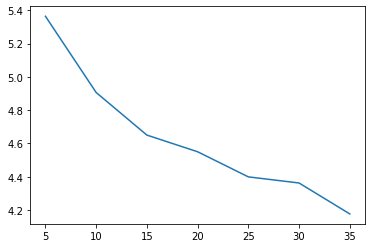

In [30]:
import matplotlib.pyplot as plt
plt.plot(list(result.keys()),list(float(mean(value)/2000) for value in result.values()))

In [31]:
if not os.path.exists('result'):
    os.mkdir('result')
os.chdir('result/')
if not os.path.exists('hops'):
    os.mkdir('cache_size')
os.chdir('hops')
filename = 'result_MPC.pickle'
import pickle
f = open(filename, 'wb')
pickle.dump(result,f)
f.close()

## 🥸 Test and demo

In [ ]:
offset = [0,2,4,6,8,10,12,14,16,18,20]
contents = ["/content/%s"%str(i) for i in range(1000)]
patterns = {}
for i in range(len(offset)):
    req, pattern = gen_bilateral_biased_zipf_requests(alpha = 1,number_of_content = 1000, number_of_request = 10000, offset = offset[i])
    patterns[i] = pattern
    #plt.plot(pattern.keys(), pattern.values())
    
data = []

for i in range(len(offset)):
    #print(patterns[i])
    data.append(patterns[i][502])
plt.plot(data)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(result)

In [ ]:
#TOPOLOGY_GRAPH = options.network_topology
#G = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
G = executor.topology
topo_vis = vis(G, executor.topology_coords)
node = random.choice(list(G.nodes()))
G.add_node("server", label = "server")
G.add_edge(node,"server")

In [ ]:
AS1 = AS(list(G.nodes()),True)
print(AS1.get_nodes())
AS1.get_node("coconut")

In [ ]:
        pos = executor.topology_coords
        Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
        fig = plt.figure(figsize=(10, 10))
        ax0 = fig.subplots()
        nx.draw_networkx_nodes(G, pos,  node_size = 80)
        nx.draw_networkx_edges(G,pos, alpha = 0.6)
        pos1 = {}
        for p in pos:  # raise text positions
            #pos[p] = [p[0]+0.05, p[1]+0.04]
            pos1[p] = pos[p][0]+0.005,pos[p][1]+0.003
        plt.title('label graph')
        nx.draw_networkx_labels(G, pos1,  font_size = 20)
        plt.show()
        #print(pos, pos1)

In [ ]:
pos = nx.spring_layout(G)
nx.draw(G, pos, font_size=16)
for p in pos:  # raise text positions
    pos[p][0] += 0.05
    pos[p][1] += 0.09
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
topo_vis.label_graph(font_size = 1, node_size = 210)

# 节点的介度

In [ ]:
print("Betweenness")
b = nx.betweenness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, b[v]))

print("Degree centrality")
d = nx.degree_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, d[v]))

print("Closeness centrality")
c = nx.closeness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, c[v]))

nx.draw(G, pos, font_size=16)
for p in pos:  # raise text positions
    pos[p][0] += 0.05
    pos[p][1] += 0.09
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
print(sum(d.values()))

In [ ]:
print(44/21)

In [ ]:
SOCIAL_GRAPH = options.social_graph
G = getattr(__import__('graphs.%s'%SOCIAL_GRAPH), SOCIAL_GRAPH).G
social_vis = vis(G)

In [ ]:
social_vis.degree_graph()

In [ ]:
social_vis.simple_graph(node_size = 10, alpha = 0.2, size = 12)

In [ ]:
print("Betweenness")
b = nx.betweenness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, b[v]))

print("Degree centrality")
d = nx.degree_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, d[v]))

print("Closeness centrality")
c = nx.closeness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, c[v]))

pos = nx.spring_layout(G)
nx.draw(G, pos, font_size=16)
for p in pos:  # raise text positions
    pos[p][0] += 0.05
    pos[p][1] += 0.09
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
topo_vis.directed_graph()

In [ ]:
topo_vis.degree_graph()

In [ ]:
topo_vis.simple_graph()

In [ ]:
args = '-c 2 -s lce -u facebook -t geant -p lru -f exampletrace/verysmall -d True'
(options,args) = parser.parse_args(args.split(' '))

In [ ]:
TOPOLOGY_GRAPH = options.network_topology
G = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
topo_vis = vis(G)

In [ ]:
topo_vis.degree_graph()

In [ ]:
G = nx.Graph()  # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_nodes_from("Hello")
K3 = nx.Graph([(0, 1), (1, 2), (2, 0)])
G.add_nodes_from(K3)

In [ ]:
viser = vis(G)
viser.directed_graph()

In [ ]:
viser.degree_graph()